In [1]:
import tempfile
import numpy as np

In [2]:
def midplane_velocity_profile(name, ax, pos, u, h, N, marker, color):
    size = 10 
    y_min = min(pos[1])
    y_max = max(pos[1])
    midpoint = (y_max - y_min)/2
    xs = pos[0]
    ys = pos[1]
    midplane = [i for i, (_, y) in enumerate(zip(xs, ys)) if abs(y - midpoint) < h]
    xs_midplane = [xs[i] for i in midplane]
    uy_midplane = [u[1][i] for i in midplane]
    ax.scatter(xs_midplane, uy_midplane, s=size, color=color, marker=marker, facecolors='none', label=name)
    ax.set_xlabel('$p_x$')
    ax.set_ylabel('$u_y$')
    ax.set_title(f"Cross section velocity for N = {N}")
    ax.legend(loc='lower left')

# Execute all versions of lid driven cavity problem

In [3]:
from pathlib import Path
from xml.etree import ElementTree
path = "bin"
programs = {
    "Lid driven cavity": ("SparseLUWrapper", "SparseLUWrapper"),
    "Lid driven cavity QR GPU": ("QR", "SparseLUWrapper"),
    # "Lid driven cavity iterative GPU" : "lidDrivenIterativeGPU" # useless...
    "Lid driven cavity GPU with DSS" : ("DSS", "SparseLUWrapper"),
    "Lid driven cavity GPU with DSS and RF" : ("DSS", "RF")
}
hs = [h/1000.0 for h in range(20, 2, -2)]
# hs = np.linspace(0.002, 0.02, 20)
param_directory = tempfile.TemporaryDirectory()

Create parameter files

In [4]:
def get_output_path(program, h):
    h_str = str(h)[2:]
    return Path("benchmark", "results", f"lidDriven_{program}_{h_str}_result.h5")
def get_param_path(param_dir, program, h):
    h_str = str(h)[2:]
    return Path(param_dir.name, f"chanelFlow_{program}_{h_str}.xml")

In [5]:
parameter_path = Path("..", "params")
default_param = parameter_path / "chanelFlow.xml"
for name, (solver_u, solver_p) in programs.items():
    params_tree = ElementTree.parse(default_param)
    root = params_tree.getroot()
    for h in hs:
        num_xml = root.find("./num")
        num_xml.set('h', str(h))
        case_xml = root.find("./case")
        case_xml.set('solver_u', solver_u)
        case_xml.set('solver_p', solver_p)
        output = root.find("./output")
        output.set("hdf5_name", str(Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)))
        param_output_path = get_param_path(param_directory, f"{solver_u}_{solver_p}", h)
        params_tree.write(param_output_path)

Run program for every parameter file

In [6]:
import subprocess
from concurrent.futures.process import ProcessPoolExecutor
def run_lid_driven(param_file):
    subprocess.run(["../bin/lidDriven", param_file])
parameter_dir = Path("..", "params", "benchmark")
to_run = []
for param_file in Path(param_directory.name).glob("*.xml"):
    params_tree = ElementTree.parse(param_file)
    root = params_tree.getroot()
    output_xml = root.find("./output")
    output_path = Path(output_xml.get("hdf5_name"))
    if Path.exists(output_path):
        continue
    to_run.append(param_file)
list(map(run_lid_driven, to_run))
# with ProcessPoolExecutor(4) as pool:
#     pool.map(run_lid_driven, to_run)


[]

Display benchmarking results

In [7]:
import matplotlib.pyplot as plt
import h5py
import numpy as np

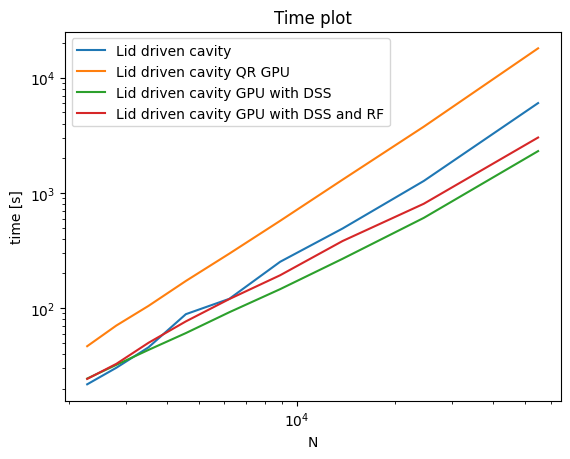

In [8]:
fig, ax = plt.subplots()
for name, (solver_u, solver_p) in programs.items():
    ts = []
    Ns = []
    for h in hs:
        result_file = Path("..") / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            time = f['times'].attrs["time"]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            ts.append(time)
    ax.plot(Ns, ts, label=name)
# plt.gca().invert_xaxis()
ax.set_xlabel('N')
ax.set_ylabel('time [s]')
plt.yscale('log')
plt.xscale('log')
ax.set_title("Time plot")
ax.legend()

[5.94047609e-18 1.00000000e+00 5.36299848e-18 ... 6.71766931e-02
 8.47643294e-02 7.25633610e-02]
[9.54078606e-18 1.00000000e+00 1.53115938e-17 ... 6.71766931e-02
 8.47643294e-02 7.25633610e-02]
[0.         1.         0.         ... 0.06717669 0.08476433 0.07256336]
[0.         1.         0.         ... 0.06717669 0.08476433 0.07256336]


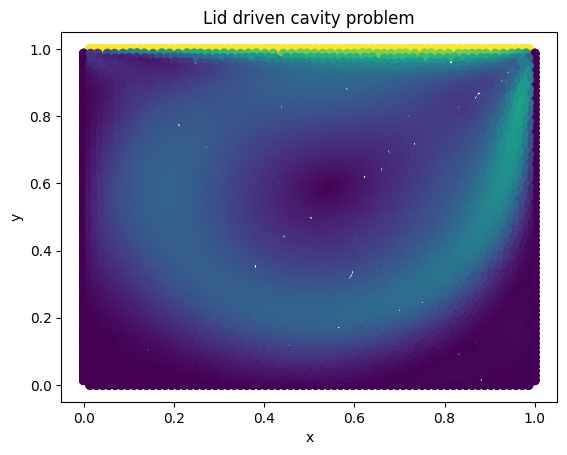

In [9]:
# fig, axs = plt.subplots(3, 3, figsize=(16,16))
fig, ax = plt.subplots()
# for i, h in enumerate(hs):
h = hs[3]
for j, (name, (solver_u, solver_p)) in enumerate(programs.items()):
    result_file = Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)
    with h5py.File(result_file) as f:
        u = np.array(f['velocity'], dtype=np.float64)
        pos = np.array(f['domain/pos'], dtype=np.float64)
        N = len(f['domain/pos'][0])
        u_norm = np.linalg.norm(u, axis=0)
        print(u_norm)
        ax.scatter(pos[0], pos[1],c=u_norm)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title('Lid driven cavity problem')
        

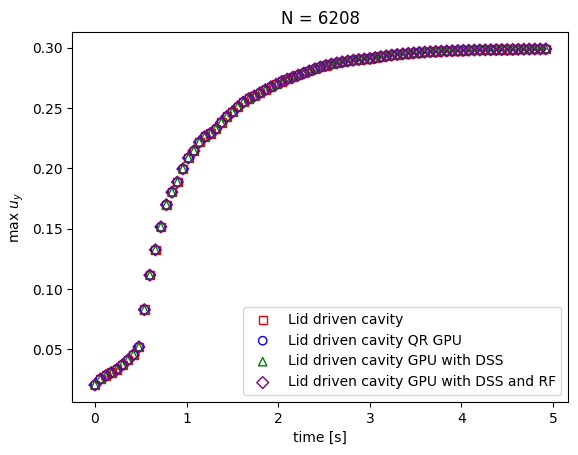

In [10]:
# fig, axs = plt.subplots(len(hs), figsize=(8,32))
# for i, h in enumerate(hs):
#     for name, (solver_u, solver_p) in programs.items():
#         result_file = Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)
#         with h5py.File(result_file) as f:
#             velocity = np.array(f['max_u_y'], dtype=np.float64)
#             xs = list(range(len(velocity[0])))
#             axs[i].plot(xs, velocity[0], label=name)
#             axs[i].set_title('Maximum midplane velocity')
#             axs[i].set_xlabel('time')
#             axs[i].set_ylabel('max $u_y$')
#             axs[i].legend()
# fig, axs = plt.subplots(3, 3, figsize=(16,16))
fig, ax= plt.subplots()
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['s', 'o', '^', 'D']
# for i, h in enumerate(hs):
j = 0
h = hs[4]
for name, (solver_u, solver_p) in programs.items():
    result_file = Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)
    with h5py.File(result_file) as f:
        velocity = np.array(f['max_u_y'], dtype=np.float64)
        dt = f.attrs['num.cfl'] * f.attrs['num.h'] / f.attrs['case.dim']
        xs = [dt * step for step in range(len(velocity[0]))]
        ax.scatter(xs, velocity[0], label=name, color=colors[j], facecolors='none', marker=markers[j])
        ax.legend(loc='lower right')
        ax.set_xlabel('time [s]')
        ax.set_ylabel('max $u_y$')
        N = len(f['domain/pos'][0])
        ax.set_title(f"N = {N}")
        j += 1


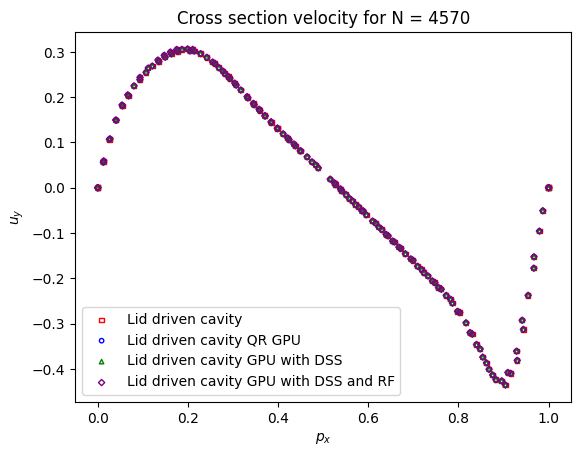

In [11]:
# fig, axs = plt.subplots(3, 3, figsize=(16,16))
fig, ax = plt.subplots()
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['s', 'o', '^', 'D']
# for i, h in enumerate(hs):
h = hs[3]
for j, (name, (solver_u, solver_p)) in enumerate(programs.items()):
    result_file = Path('..') / get_output_path(f"{solver_u}_{solver_p}", h)
    with h5py.File(result_file) as f:
        u = np.array(f['velocity'], dtype=np.float64)
        pos = np.array(f['domain/pos'], dtype=np.float64)
        N = len(f['domain/pos'][0])
        
        midplane_velocity_profile(name, ax, pos, u, h, N, markers[j], colors[j])

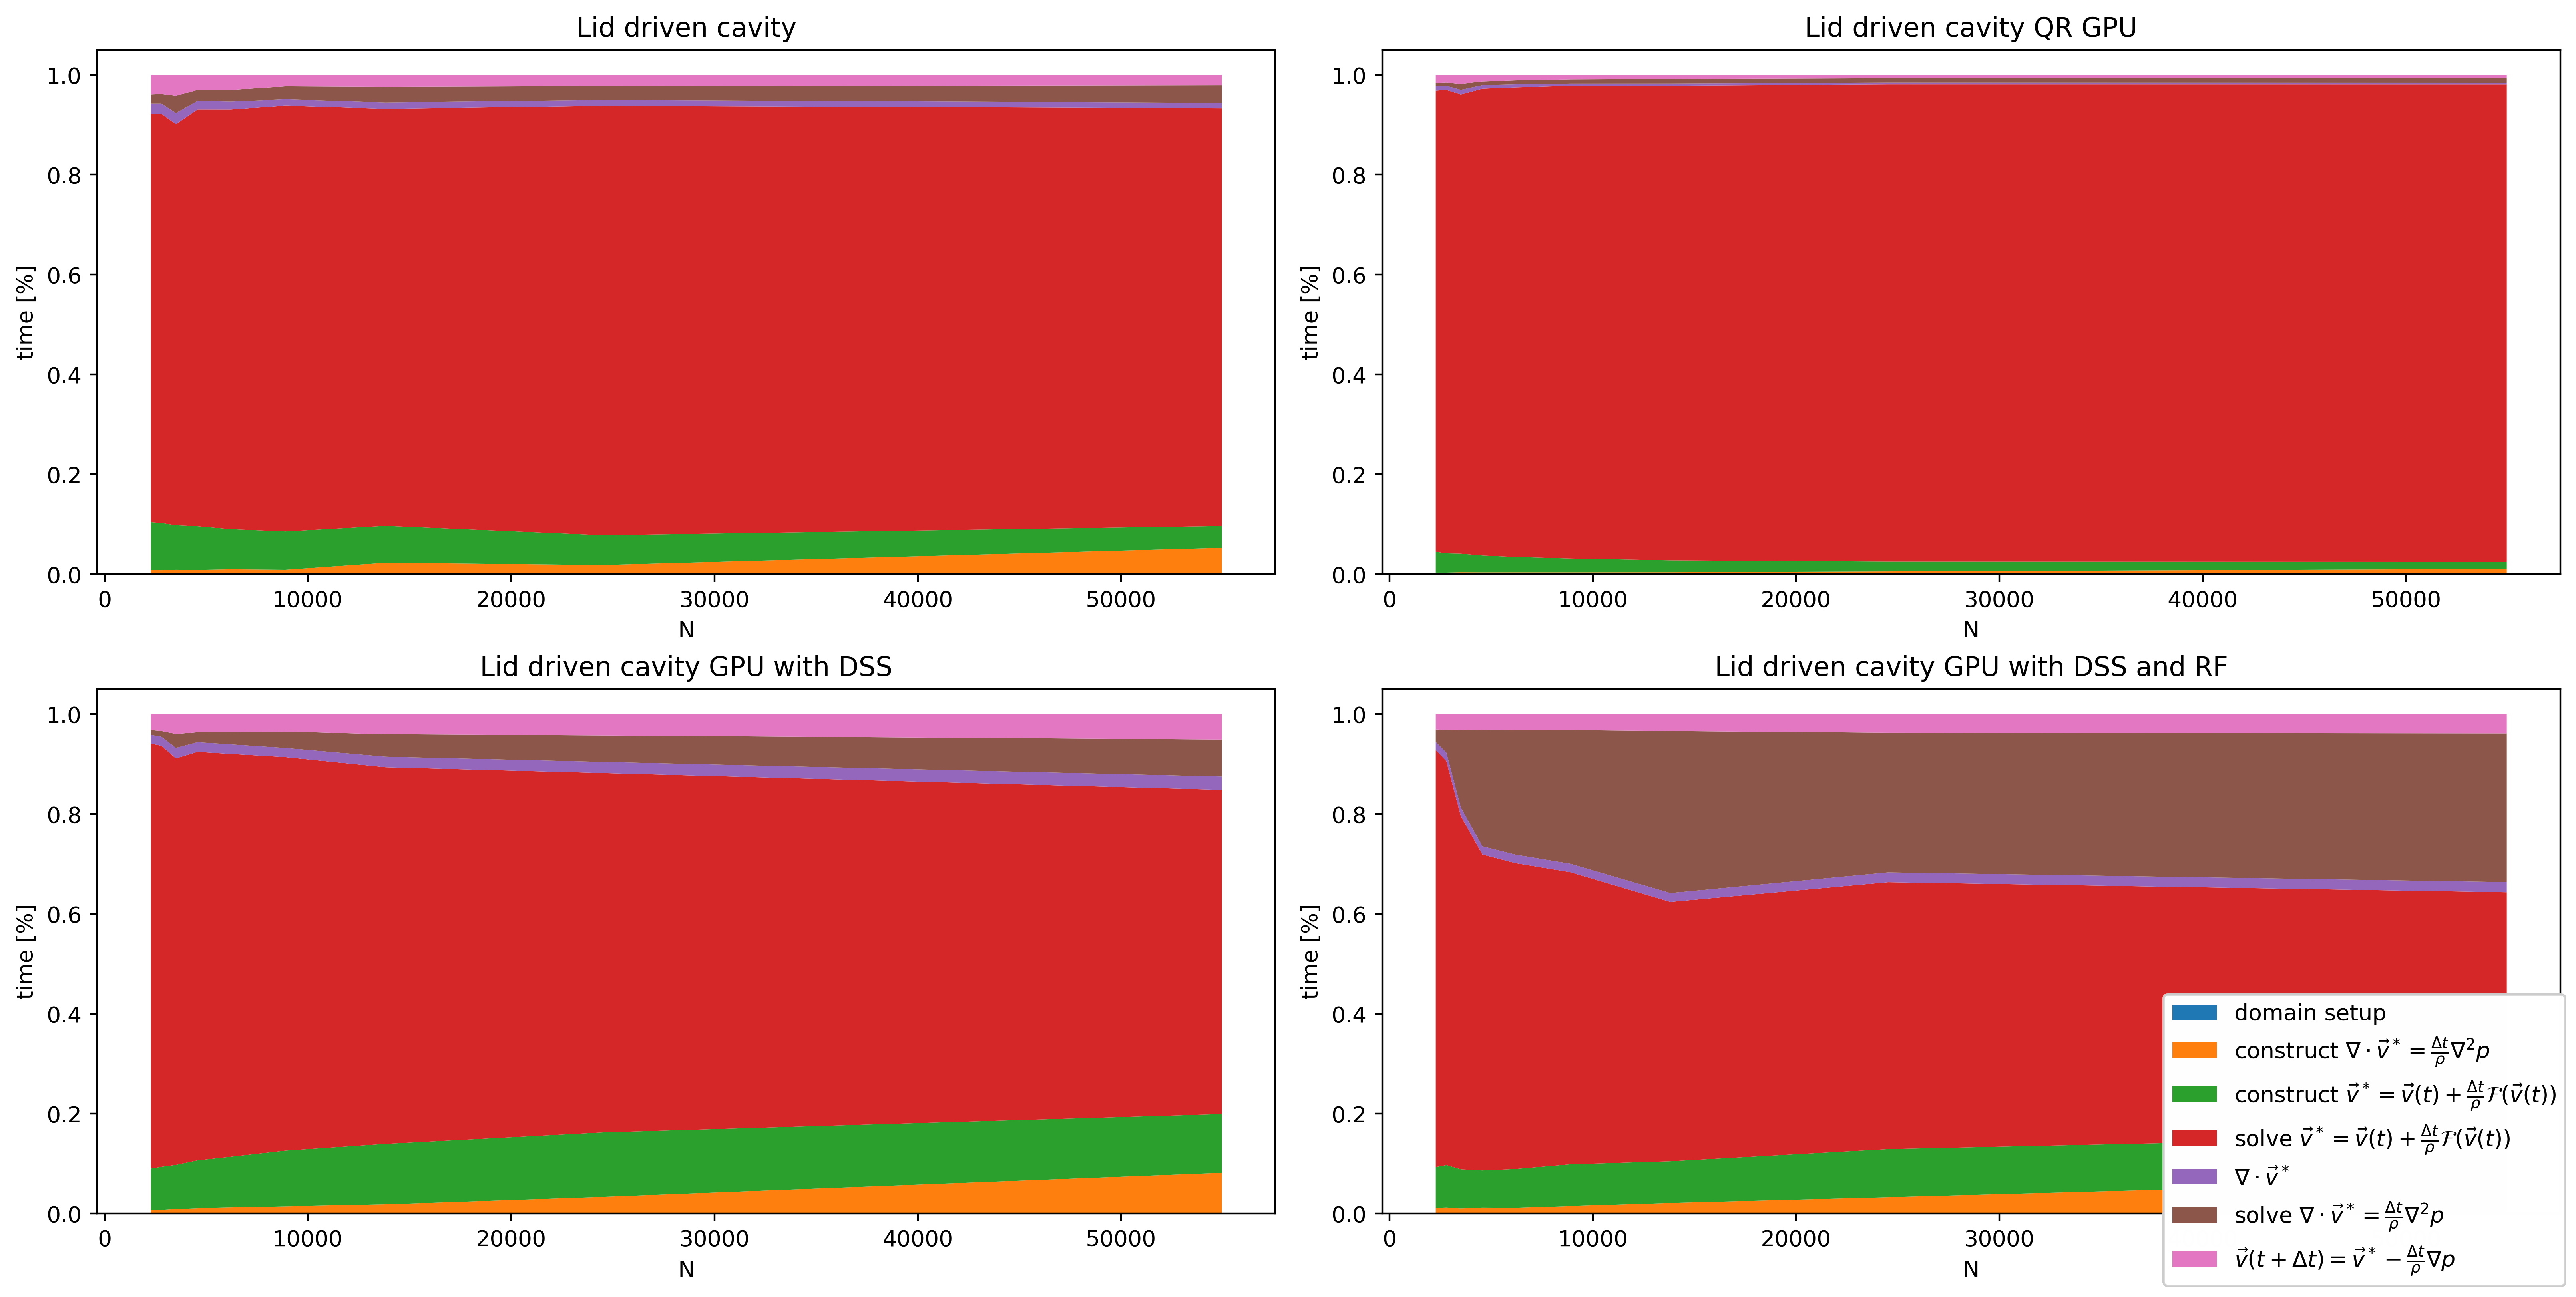

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8), constrained_layout=True)
fig.set_dpi(400)
times = {"domain setup": "domain setup", 
         "M_p construction": r'construct $\nabla \cdot \vec{v}^* = \frac{\Delta t}{\rho}\nabla^2 p$', 
        #  "M_p construction": r'$\nabla$', 
         "M_u construction": r"construct $\vec{v}^* = \vec{v}(t) + \frac{\Delta t}{\rho}\mathcal{F}(\vec{v}(t))$", 
         "M_u solve": r"solve $\vec{v}^* = \vec{v}(t) + \frac{\Delta t}{\rho}\mathcal{F}(\vec{v}(t))$", 
         "rhs_p": r"$\nabla \cdot \vec{v}^*$", 
         "M_p solve": r"solve $\nabla \cdot \vec{v}^*= \frac{\Delta t}{\rho}\nabla^2 p$", 
         "pressure correction": r"$\vec{v}(t + \Delta t) = \vec{v}^* -\frac{\Delta t}{\rho} \nabla p$", 
         }
# plt.rcParams['text.usetex'] = True
for i, (name, (solver_u, solver_p)) in enumerate(programs.items()):
    ts = {} 
    for time_name in times.keys():
        ts[time_name] = []
    Ns = []
    for h in hs:
        result_file = Path("..") / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            # time = f.attrs["time"] - f.attrs["setup"]
            for time_name, formated_name in times.items():
                ts[time_name].append(f['times'].attrs[time_name])
            # total = sum(ts)
            # ts = [t/total for t in ts]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
    sorted_names = []
    col_total = np.zeros(len(hs))
    values = []
    # total = np.array(len())
    for time_name, value in ts.items():
        sorted_names.append(times[time_name])
        col_total += value
        values.append(value)

    for j in range(len(values)):
        values[j] /= col_total
    values = np.vstack(values)
    ax[i//2][i%2].stackplot(Ns, values, labels=sorted_names)
    # ax[i//2][i%2].legend(loc = 'lower right')
    fig.legend(labels=sorted_names,loc = 'lower right')
    ax[i//2][i%2].set_title(name)
    ax[i//2][i%2].set_xlabel("N")
    ax[i//2][i%2].set_ylabel("time [%]")

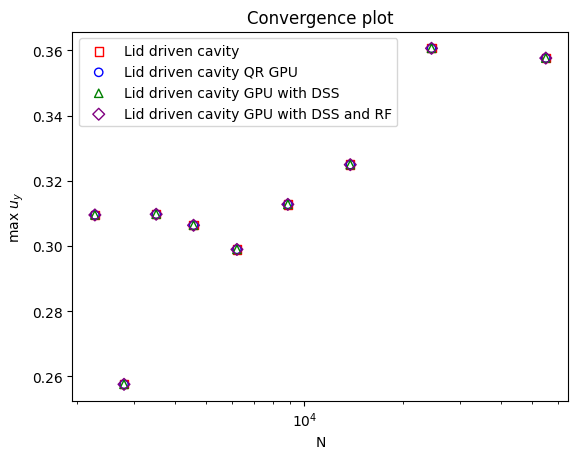

In [13]:
fig, ax = plt.subplots()
colors = ['red', 'blue', 'green', 'purple', 'orange']
markers = ['s', 'o', '^', 'D']
for j, (name, (solver_u, solver_p)) in enumerate(programs.items()):
    vs = []
    Ns = []
    for h in hs:
        result_file = Path("..") / get_output_path(f"{solver_u}_{solver_p}", h)
        with h5py.File(result_file) as f:
            velocity = np.array(f['max_u_y'], dtype=np.float64)
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            vs.append(velocity[0][-1])
    ax.scatter(Ns, vs, label=name, color=colors[j], facecolors='none', marker=markers[j])
# plt.gca().invert_xaxis()
ax.set_xlabel('N')
ax.set_ylabel('max $u_y$')
# plt.yscale('log')
plt.xscale('log')
ax.set_title("Convergence plot")
ax.legend()

In [14]:
programs_acm = {
    # "Lid driven cavity ACM": "lidDrivenACM",
    "Lid driven cavity matrix ACM": "lidDrivenMatrixACM",
    "Lid driven cavity matrix GPU ACM": "lidDrivenMatrixACMGPU",
    "Lid driven cavity ACM SYCL": "lidDrivenACMSYCL"
}
hs_acm = [h / 1000.0 for h in range(20, 0, -2)] #+ [1 / 1000.0]
hs_acm += [h / 10000.0 for h in range(20, 10, -2)]
print(hs_acm)
# hs_acm = np.linspace(0.001, 0.02, 20)
acm_parameter_dir = tempfile.TemporaryDirectory()

[0.02, 0.018, 0.016, 0.014, 0.012, 0.01, 0.008, 0.006, 0.004, 0.002, 0.002, 0.0018, 0.0016, 0.0014, 0.0012]


In [15]:
def create_config(params, output_loc):
    parameter_path = Path("..", "params")
    default_param = parameter_path / "chanelFlowACM.xml"
    params_tree = ElementTree.parse(default_param)
    root = params_tree.getroot()
    for (element, node), value in params.items():
        el = root.find(element)
        el.set(node, value)
    # param_output_path = get_param_path(acm_parameter_dir, program, h)
    print(output_loc)
    params_tree.write(output_loc)

In [16]:
program = "lidDrivenMatrixACM"
for h in hs_acm:
    for num_threads in [4, 8, 16]:
        thread_prog = f"{program}_{num_threads}"
        params = {
            ("num", "h"): str(h),
            ("output", "hdf5_name"): str(Path("..") / get_output_path(thread_prog, str(h))),
            ("case", "program"): program,
            ("sys", "num_threads"): str(num_threads)

        }
        create_config(params, get_param_path(acm_parameter_dir, thread_prog, str(h)))

/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_4_02.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_8_02.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_16_02.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_4_018.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_8_018.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_16_018.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_4_016.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_8_016.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_16_016.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_4_014.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_8_014.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_16_014.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_4_012.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_8_012.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_16_012.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_4_01.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACM_8_01.xml
/tmp/tmpb3ikwf1u/chanelFlow_lid

In [17]:
program = "lidDrivenMatrixACMGPU"
for h in hs_acm:
    params = {
        ("num", "h"): str(h),
        ("output", "hdf5_name"): str(Path("..") / get_output_path(program, str(h))),
        ("case", "program"): program
    }
    create_config(params, get_param_path(acm_parameter_dir, program, str(h)))

/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_02.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_018.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_016.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_014.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_012.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_01.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_008.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_006.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_004.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_002.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_002.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_0018.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_0016.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_0014.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenMatrixACMGPU_0012.xml


In [18]:
program = "lidDrivenACMSYCL"
for h in hs_acm:
    for device in ["cpu", "gpu"]:
        prog = f"{program}_{device}"
        params = {
            ("num", "h"): str(h),
            ("output", "hdf5_name"): str(Path("..") / get_output_path(prog, str(h))),
            ("case", "program"): program,
            ("case", "device"): device
        }
        create_config(params, get_param_path(acm_parameter_dir, prog, str(h)))

/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_cpu_02.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_gpu_02.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_cpu_018.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_gpu_018.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_cpu_016.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_gpu_016.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_cpu_014.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_gpu_014.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_cpu_012.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_gpu_012.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_cpu_01.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_gpu_01.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_cpu_008.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_gpu_008.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_cpu_006.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_gpu_006.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDrivenACMSYCL_cpu_004.xml
/tmp/tmpb3ikwf1u/chanelFlow_lidDriv

In [19]:
# parameter_path = Path("..", "params")
# default_param = parameter_path / "chanelFlowACM.xml"
# for name, program in programs_acm.items():
#     params_tree = ElementTree.parse(default_param)
#     root = params_tree.getroot()
#     for h in hs_acm:
#         num_xml = root.find("./num")
#         num_xml.set('h', str(h))
#         output = root.find("./output")
#         output.set("hdf5_name", str(Path('..') / get_output_path(program, h)))
#         case_xml = root.find("./case")
#         case_xml.set('program', program)
#         param_output_path = get_param_path(acm_parameter_dir, program, h)
#         params_tree.write(param_output_path)

In [20]:
import subprocess
import os
from concurrent.futures.process import ProcessPoolExecutor
def run_lid_driven_acm(program, param_file):
    subprocess.run([f"../bin/{program}", param_file])
parameter_dir = Path("..", "params", "benchmark")
to_run = []
to_run_programs = []
for param_file in Path(acm_parameter_dir.name).glob("*.xml"):
    params_tree = ElementTree.parse(param_file)
    root = params_tree.getroot()
    output_xml = root.find("./output")
    output_path = Path(output_xml.get("hdf5_name"))
    if Path.exists(output_path):
        print(f"Skipping: {output_path}")
        continue
    print(f"Executing {output_path}")
    case_xml = root.find("./case")
    program = case_xml.get("program")
    # to_run.append((program, param_file))
    to_run_programs.append(program)
    to_run.append(param_file)
print(to_run)
# with ProcessPoolExecutor(1) as pool:
    # pool.map(run_lid_driven_acm, to_run_programs, to_run)
list(map(run_lid_driven_acm, to_run_programs, to_run))


Skipping: ../benchmark/results/lidDriven_lidDrivenMatrixACM_16_01_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenACMSYCL_cpu_016_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenMatrixACM_16_0014_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenMatrixACMGPU_006_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenMatrixACM_4_0012_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenMatrixACM_16_004_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenMatrixACM_4_006_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenACMSYCL_cpu_02_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenMatrixACM_8_0018_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenMatrixACM_16_0018_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenACMSYCL_cpu_012_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenACMSYCL_gpu_004_result.h5
Skipping: ../benchmark/results/lidDriven_lidDrivenMatrixACM_8_012_result.h5
Skipp

[]

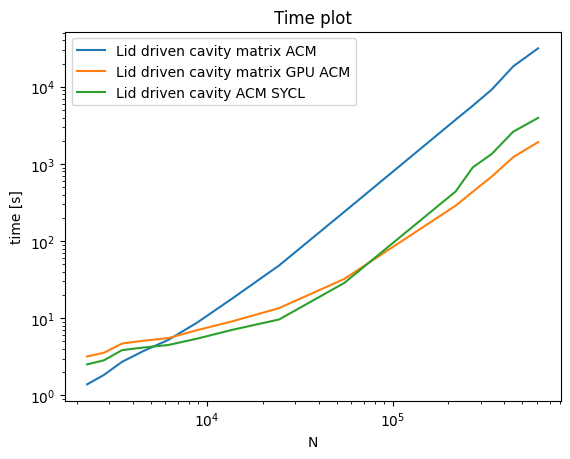

In [21]:
fig, ax = plt.subplots()
for name, program in programs_acm.items():
    ts = []
    Ns = []
    for h in hs_acm:
        result_file = Path("..") / get_output_path(program, h)
        with h5py.File(result_file) as f:
            if program == 'lidDrivenMatrixACM':
                time = f["times"].attrs["time"] - f["times"].attrs["setup"]
            elif program == 'lidDrivenMatrixACMGPU':
                # print(list(f.attrs))
                time = f.attrs["time"] - f.attrs["setup"]
            else:
                time = f.attrs["time"]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            ts.append(time)
            # print(name)
    ax.plot(Ns, ts, label=name)
# plt.gca().invert_xaxis()
ax.set_xlabel('N')
ax.set_ylabel('time [s]')
plt.yscale('log')
plt.xscale('log')
ax.set_title("Time plot")
ax.legend()

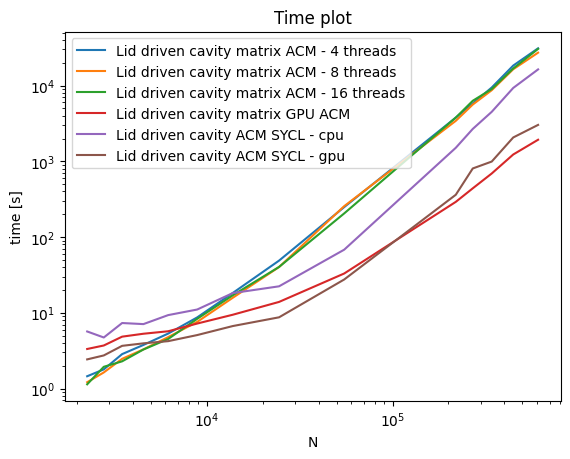

In [79]:
fig, ax = plt.subplots()


def time_plot(name, program, ax):
    ts = []
    Ns = []
    for h in hs_acm:
        res = str(Path("..") / get_output_path(program, str(h)))
        with h5py.File(res) as f:
            if "lidDrivenMatrixACM_" in program:
                time =  f["times"].attrs["time"] - f["times"].attrs["setup"]
            else:
                time = f.attrs["time"]

            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            ts.append(time)
    ax.plot(Ns, ts, label=name)

for name, program in programs_acm.items():
    match program:
        case "lidDrivenMatrixACM":
            for num_threads in [4, 8, 16]:
                time_plot(f"{name} - {num_threads} threads", f"{program}_{num_threads}", ax)
        case "lidDrivenACMSYCL":
            for device in ["cpu", "gpu"]:
                time_plot(f"{name} - {device}", f"{program}_{device}", ax)
        case "lidDrivenMatrixACMGPU":
            time_plot(name, program, ax)
# plt.gca().invert_xaxis()
ax.set_xlabel("N")
ax.set_ylabel("time [s]")
plt.yscale("log")
plt.xscale("log")
ax.set_title("Time plot")
ax.legend()

In [62]:
def draw_scatter(name, program, h, color, marker, ax):
    N = 0
    res = str(Path("..") / get_output_path(program, str(h)))
    with h5py.File(res) as f:
        velocity = np.array(f['max_u_y'], dtype=np.float64)
        dt1 = f.attrs['num.cfl'] * f.attrs['num.h'] / f.attrs['case.dim']
        dt2 = f.attrs['num.cfl'] / 10 * f.attrs['num.h'] ** 2 * f.attrs['case.Re']
        dt = min(dt1, dt2)
        N = len(f['domain/pos'][0])
        xs = [dt * step for step in range(len(velocity[0]))]
        ax.scatter(xs, velocity[0], label=name, color=color, facecolors='none', marker=marker)
    return N
def draw_scatter_plots(programs):
    fig, ax = plt.subplots()
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    markers = ['s', 'o', '^', 'D']
    j = 0
    h = hs_acm[1]
    for name, program in programs:
        N = draw_scatter(name, program, h, colors[j], markers[j], ax)
        j += 1
    ax.legend(loc='lower right')
    ax.set_xlabel('time [s]')
    ax.set_ylabel('max $u_y$')
    ax.set_title(f"N = {N}")

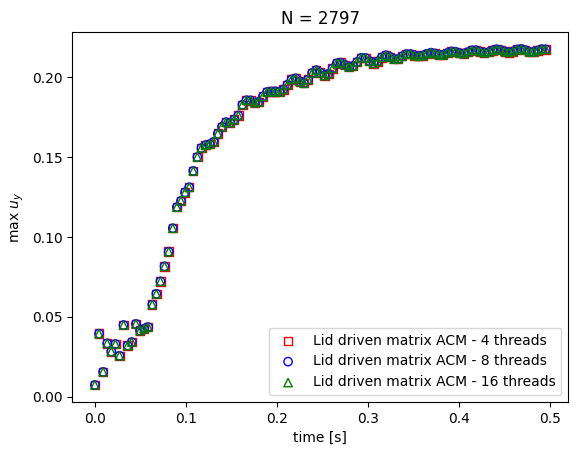

In [63]:
programs = [(f"Lid driven matrix ACM - {num_threads} threads", f"lidDrivenMatrixACM_{num_threads}") for num_threads in [4, 8, 16]]
draw_scatter_plots(programs)

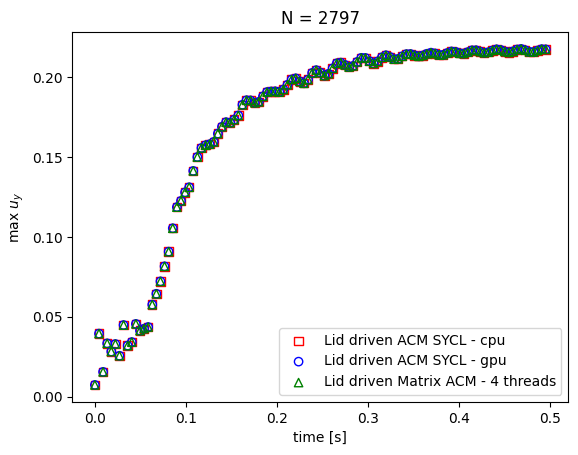

In [65]:
programs = [
    (f"Lid driven ACM SYCL - {device}", f"lidDrivenACMSYCL_{device}")
    for device in ["cpu", "gpu"]
] + [("Lid driven Matrix ACM - 4 threads", "lidDrivenMatrixACM_4")]
draw_scatter_plots(programs)

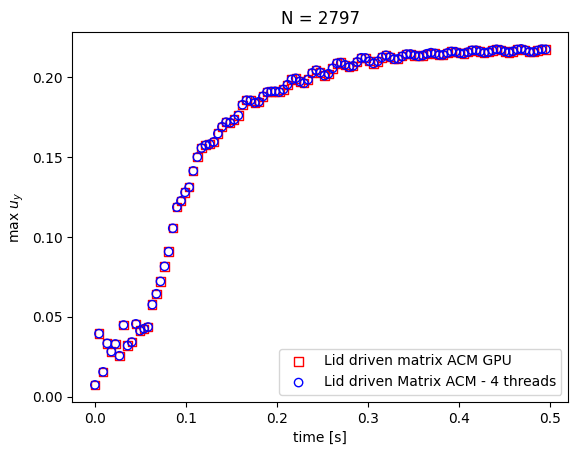

In [66]:
programs = [
    ("Lid driven matrix ACM GPU", "lidDrivenMatrixACMGPU"),
    ("Lid driven Matrix ACM - 4 threads", "lidDrivenMatrixACM_4"),
]
draw_scatter_plots(programs)

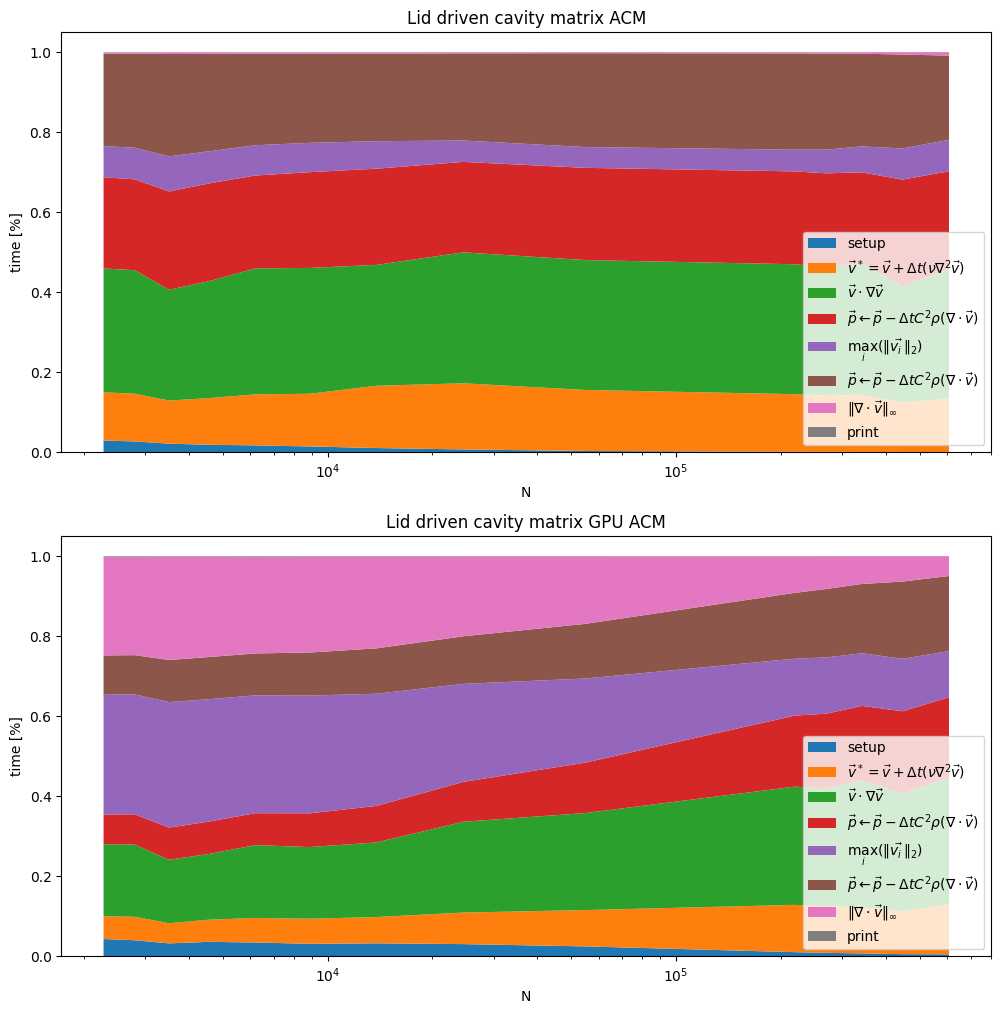

In [67]:
fig, ax = plt.subplots(2, figsize=(12, 12))
times = {"setup": "setup", 
         "u = u + dt / Re * lap * u": r"$\vec{v}^* = \vec{v} + \Delta t \left( \nu \nabla^2 \vec{v} \right)$", 
         "advection": r"$\vec{v} \cdot \nabla\vec{v}$", 
         "PV correction": r"$\vec{p}  \leftarrow \vec{p} - \Delta t C^2  \rho  (\nabla \cdot \vec{v})$", 
         "max_norm": r"$\max_i(\| \vec{v_i}\|_2)$", 
         "p": r"$\vec{p}  \leftarrow \vec{p} - \Delta t C^2  \rho  (\nabla \cdot \vec{v})$", 
         "max_div": r"$\| \nabla \cdot \vec{v}\|_{\infty}$", 
         "print": "print"}
for i, (name, program) in enumerate(programs_acm.items()):
    if program == "lidDrivenACMSYCL":
        continue
    ts = {} 
    for time_name in times.keys():
        ts[time_name] = []
    Ns = []
    for h in hs_acm:
        result_file = Path("..") / get_output_path(program, h)
        with h5py.File(result_file) as f:
            # time = f.attrs["time"] - f.attrs["setup"]
            for time_name, formated_name in times.items():
                if program != 'lidDrivenMatrixACM':
                    ts[time_name].append(f.attrs[time_name])
                else:
                    ts[time_name].append(f["times"].attrs[time_name])
            N = len(f["domain/pos"][()][0])
            Ns.append(N)

    sorted_names = []
    col_total = np.zeros(len(hs_acm))
    values = []
    # total = np.array(len())
    for time_name, value in ts.items():
        sorted_names.append(times[time_name])
        col_total += value
        values.append(value)

    for j in range(len(values)):
        values[j] /= col_total
    values = np.vstack(values)

    ax[i].set_xlabel('N')
    ax[i].set_ylabel('time [%]')
    ax[i].stackplot(Ns, values, labels=sorted_names)
    ax[i].legend(loc = 'lower right')
    ax[i].set_title(name)
    ax[i].set_xscale('log')
    # ax[i].set_yscale("log")

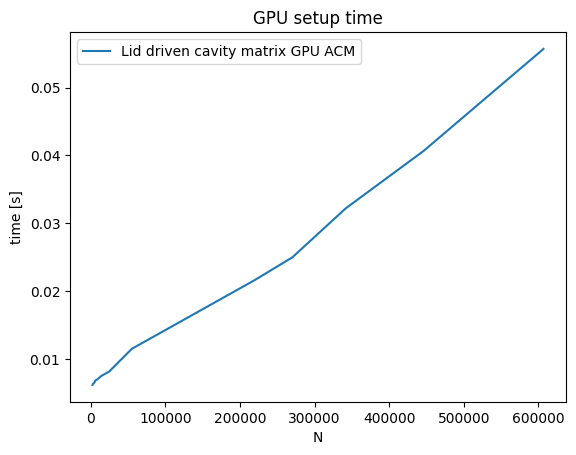

In [69]:
fig, ax = plt.subplots()
for name, program in programs_acm.items():
    if program in ["lidDrivenMatrixACM", "lidDrivenACMSYCL"]:
        continue
    ts = []
    Ns = []
    for h in hs_acm:
        result_file = Path("..") / get_output_path(program, h)
        with h5py.File(result_file) as f:
            time = f.attrs["gpu setup"]
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            ts.append(time)
    ax.plot(Ns, ts, label=name)
# plt.gca().invert_xaxis()
ax.set_xlabel('N')
ax.set_ylabel('time [s]')
# plt.yscale('log')
ax.set_title("GPU setup time")
ax.legend()

In [81]:
def midplane_graph(name, program, h, color, marker, ax):
    result_file = Path('..') / get_output_path(program, h)
    N = 0
    with h5py.File(result_file) as f:
        u = np.array(f['velocity'], dtype=np.float64)
        pos = np.array(f['domain/pos'], dtype=np.float64)
        N = len(f['domain/pos'][0])
        midplane_velocity_profile(name, ax, pos, u, h, N, marker, color)
    return N
def midplane_plot(programs):
    fig, ax = plt.subplots()
    h = hs_acm[0]
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    markers = ['s', 'o', '^', 'D']
    j = 0
    for name, program in programs:
        N = midplane_graph(name, program, h, colors[j], markers[j], ax)
        j += 1

    ax.legend(loc='lower right')
    ax.set_xlabel('time [s]')
    ax.set_ylabel('max $u_y$')
    ax.set_title(f"N = {N}")

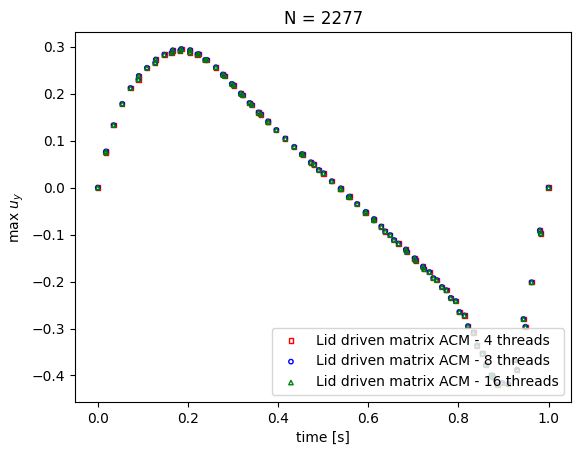

In [82]:
programs = [(f"Lid driven matrix ACM - {num_threads} threads", f"lidDrivenMatrixACM_{num_threads}") for num_threads in [4, 8, 16]]
midplane_plot(programs)

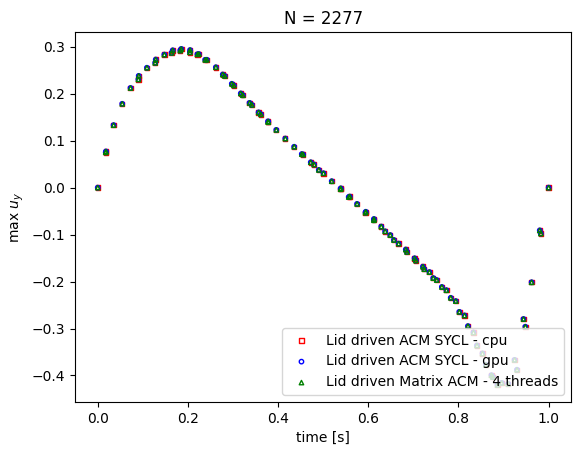

In [83]:
programs = [
    (f"Lid driven ACM SYCL - {device}", f"lidDrivenACMSYCL_{device}")
    for device in ["cpu", "gpu"]
] + [("Lid driven Matrix ACM - 4 threads", "lidDrivenMatrixACM_4")]
midplane_plot(programs)

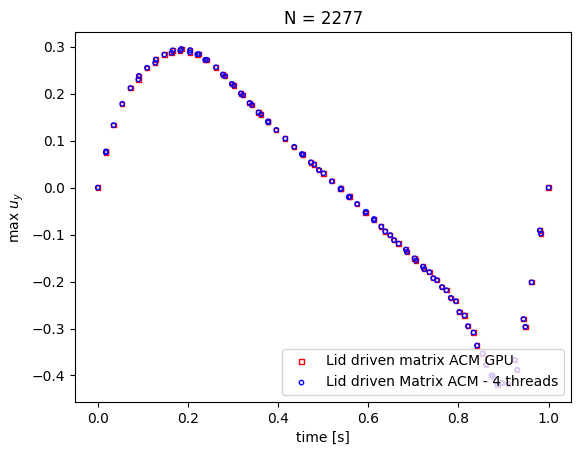

In [84]:
programs = [
    ("Lid driven matrix ACM GPU", "lidDrivenMatrixACMGPU"),
    ("Lid driven Matrix ACM - 4 threads", "lidDrivenMatrixACM_4"),
]
midplane_plot(programs)

In [91]:
def convergence_graph(name, program, h, marker, color, ax):
    vs = []
    Ns = []
    for h in hs:
        result_file = Path("..") / get_output_path(program, h)
        with h5py.File(result_file) as f:
            velocity = np.array(f['max_u_y'], dtype=np.float64)
            N = len(f["domain/pos"][()][0])
            Ns.append(N)
            vs.append(velocity[0][-1])
    ax.scatter(Ns, vs, label=name, color=color, facecolors='none', marker=marker)
def convergence_plots(programs):
    fig, ax = plt.subplots()
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'black']
    markers = ['s', 'o', '^', 'D', '*', 'h']
    j = 0
    h = hs_acm[0]
    for name, program in programs:
        N = convergence_graph(name, program, h, markers[j], colors[j], ax)
        j += 1
    ax.set_xlabel('N')
    ax.set_ylabel('max $u_y$')
    # plt.yscale('log')
    plt.xscale('log')
    ax.set_title("Convergence plot")
    ax.legend()

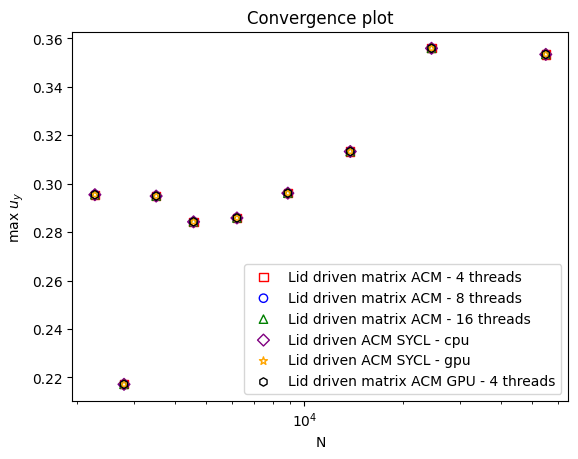

In [93]:
colors = ["red", "blue", "green", "purple", "orange"]
markers = ["s", "o", "^", "D", "*"]
programs = [
    (
        f"Lid driven matrix ACM - {num_threads} threads",
        f"lidDrivenMatrixACM_{num_threads}",
    )
    for num_threads in [4, 8, 16]
] + [
    (f"Lid driven ACM SYCL - {device}", f"lidDrivenACMSYCL_{device}")
    for device in ["cpu", "gpu"]
] + [("Lid driven matrix ACM GPU - 4 threads", "lidDrivenMatrixACMGPU")]
convergence_plots(programs)